# Course project

- 1. Скачать данные об энергоэффективности зданий Нью-Йорка https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml (2018 Energy and Water Data Disclosure (Data for Calendar Year 2017, файл spreadsheet, лист Information and Metrics)
- 2. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии и т.п.)
- 3. Провести Exploratory Data Analysis. Проанализировать переменные, влияющие на зависимую переменную - оценку энергоэффективности зданий ENERGY STAR Score.
- 4. Разделить датасет на обучающие и тестовую  выборки.
- 5. Обучить регрессионную модель и выявить показатели качества модели на обучающей и тестовой выборке.
- 6. Реализовать методы feature engineering с целью повышения метрик качества модели.


In [442]:
# импортируем необходимые нам библиотеки и методы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from category_encoders.count import CountEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [443]:
#Задаем общий стиль визуализаций

plt.style.use('seaborn-muted')

In [444]:
#Загрузка данных

df = pd.read_excel('nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name = 'Information and Metrics')

### Посмотрим на датасет, ознакомимся с признаками

In [445]:
df.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),...,Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1.010288e+09,1010287502,1024898,224 West 57th St,NaN,...,NaN,NaT,732.4,76.3,656.1,3635.5,21.46,Not found,2018-02-14,Not found
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4.018720e+09,4-01872-0007,4046340,56-25 92nd Street,NaN,...,NaN,NaT,164.5,109.9,54.6,102.9,1.09,Not found,2018-02-14,Not found
2,4,4898531,The Nomad Hotel,NaN,NaN,1.008290e+09,1-00829-0050,1080710,1170 Broadway,NaN,...,NaN,NaT,1150.2,438.0,712.3,10762.6,86.10,Not found,2018-02-14,Not found
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1.008280e+09,1-00828-0053,1015657,1155 Broadway,NaN,...,NaN,NaT,273.4,98.2,175.3,790.1,15.80,Not found,2018-02-14,Not found
4,6,3878205,Westbury Realty,NaN,NaN,1.000650e+09,1-00065-0024,1001105,24 John Street,NaN,...,NaN,NaT,90.7,0.0,90.7,143.0,2.86,Not found,2018-02-14,Not found


In [446]:
df.shape

(34355, 60)

In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       34355 non-null  int64         
 1   Property Id                                                 34355 non-null  int64         
 2   Property Name                                               34355 non-null  object        
 3   Parent Property Id                                          1723 non-null   object        
 4   Parent Property Name                                        1723 non-null   object        
 5   BBL - 10 digits                                             33625 non-null  float64       
 6   NYC Borough, Block and Lot (BBL) self-reported              33626 non-null  object        
 7   NYC Building Identific

### Посмотрим на целевую переменную

Text(0.5, 1.0, 'ENERGY STAR SCORE')

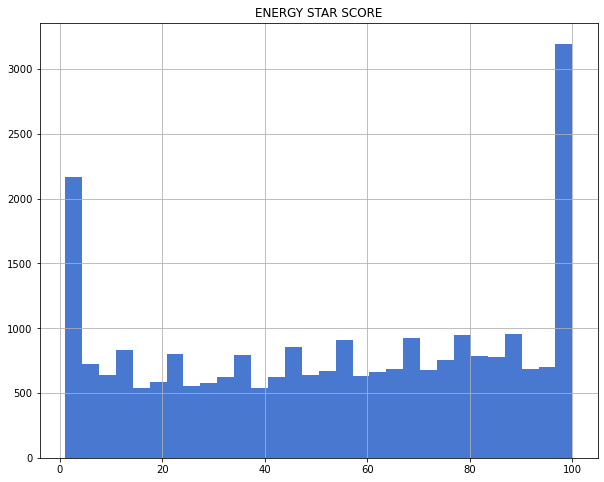

In [449]:
plt.figure(figsize=(10, 8))

df['ENERGY STAR Score'].hist(bins=30)
plt.title('ENERGY STAR SCORE')

In [450]:
target = 'ENERGY STAR Score'

In [451]:
df = df[~(df[target].isna())]
df[target].isna().sum()

0

### Oчистим неинформативные признаки

In [452]:
cols_to_del = ['Order', 'Property Id', 'Property Name', 'Parent Property Id',
               'Parent Property Name', 'BBL - 10 digits',
               'NYC Borough, Block and Lot (BBL) self-reported',
               'NYC Building Identification Number (BIN)', 'Postal Code', 'Street Number',
               'Generation Date', 'DOF Benchmarking Submission Status']

In [453]:
df = df.drop(columns=cols_to_del)

In [454]:
cols_to_del = []
for col in df.columns:
    if df[col].isna().sum() / df.shape[0] > 0.5:
        cols_to_del.append(col)

cols_to_del

['Address 2 (self-reported)',
 '2nd Largest Property Use Type',
 '2nd Largest Property Use - Gross Floor Area (ft²)',
 '3rd Largest Property Use Type',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Metered Areas  (Water)',
 'Fuel Oil #1 Use (kBtu)',
 'Fuel Oil #2 Use (kBtu)',
 'Fuel Oil #4 Use (kBtu)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Propane Use (kBtu)',
 'District Steam Use (kBtu)',
 'District Hot Water Use (kBtu)',
 'District Chilled Water Use (kBtu)',
 'Annual Maximum Demand (kW)',
 'Annual Maximum Demand (MM/YYYY)']

In [455]:
df = df.drop(columns=cols_to_del)

In [456]:
df.shape

(25454, 31)

In [457]:
object_cols_to_del = []
for col in df.columns:
    if df[col].nunique() == 1:
        object_cols_to_del.append(col)
    
object_cols_to_del

['Street Name',
 'DOF Gross Floor Area (ft²)',
 'Metered Areas (Energy)',
 'Water Required?']

In [458]:
df = df.drop(columns=object_cols_to_del)
df.shape

(25454, 27)

In [459]:
# неструктурированная переменная - удалить
df['Address 1 (self-reported)'].value_counts()[:10]

410 West 118th Street    70
Classified               23
530 Grand Street         16
144 W 14th St            14
215 Willoughby Ave       14
550 Myrtle Ave           14
395 Dekalb Ave           14
369  Dekalb Ave          14
536 Myrtle Ave           14
282 Lafayette Ave        14
Name: Address 1 (self-reported), dtype: int64

In [460]:
df = df.drop(columns=['Address 1 (self-reported)'])

### Cтроковые признаки

In [461]:
df['Borough'].value_counts()

Manhattan        9223
Brooklyn         6419
Bronx            5350
Queens           3992
Staten Island     427
brooklyn           24
BROOKLYN            9
bronx               4
BRONX               2
QUEENS              2
Patchogue           1
STATEN ISLAND       1
Name: Borough, dtype: int64

In [462]:
df['Borough'] = df['Borough'].str.lower()
df['Borough'].value_counts()

manhattan        9223
brooklyn         6452
bronx            5356
queens           3994
staten island     428
patchogue           1
Name: Borough, dtype: int64

In [470]:
object_features = df.select_dtypes(['object'])
object_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25454 entries, 0 to 34353
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Borough                                     25454 non-null  object
 1   Primary Property Type - Self Selected       25454 non-null  object
 2   List of All Property Use Types at Property  25454 non-null  object
 3   Largest Property Use Type                   25454 non-null  object
dtypes: object(4)
memory usage: 994.3+ KB


## Разделим данные на тренировочную и тестовую выборки

In [484]:
X = df.copy()
y = X.pop(target)

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
X_train.shape, X_test.shape

((20363, 25), (5091, 25))

In [486]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20363 entries, 16853 to 355
Data columns (total 25 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Borough                                                     20363 non-null  object 
 1   Self-Reported Gross Floor Area (ft²)                        20363 non-null  int64  
 2   Primary Property Type - Self Selected                       20363 non-null  object 
 3   List of All Property Use Types at Property                  20363 non-null  object 
 4   Largest Property Use Type                                   20363 non-null  object 
 5   Largest Property Use Type - Gross Floor Area (ft²)          20363 non-null  float64
 6   Year Built                                                  20363 non-null  int64  
 7   Number of Buildings                                         20363 non-null  int64  

## Посмотрим на матрицу корреляции

<AxesSubplot:>

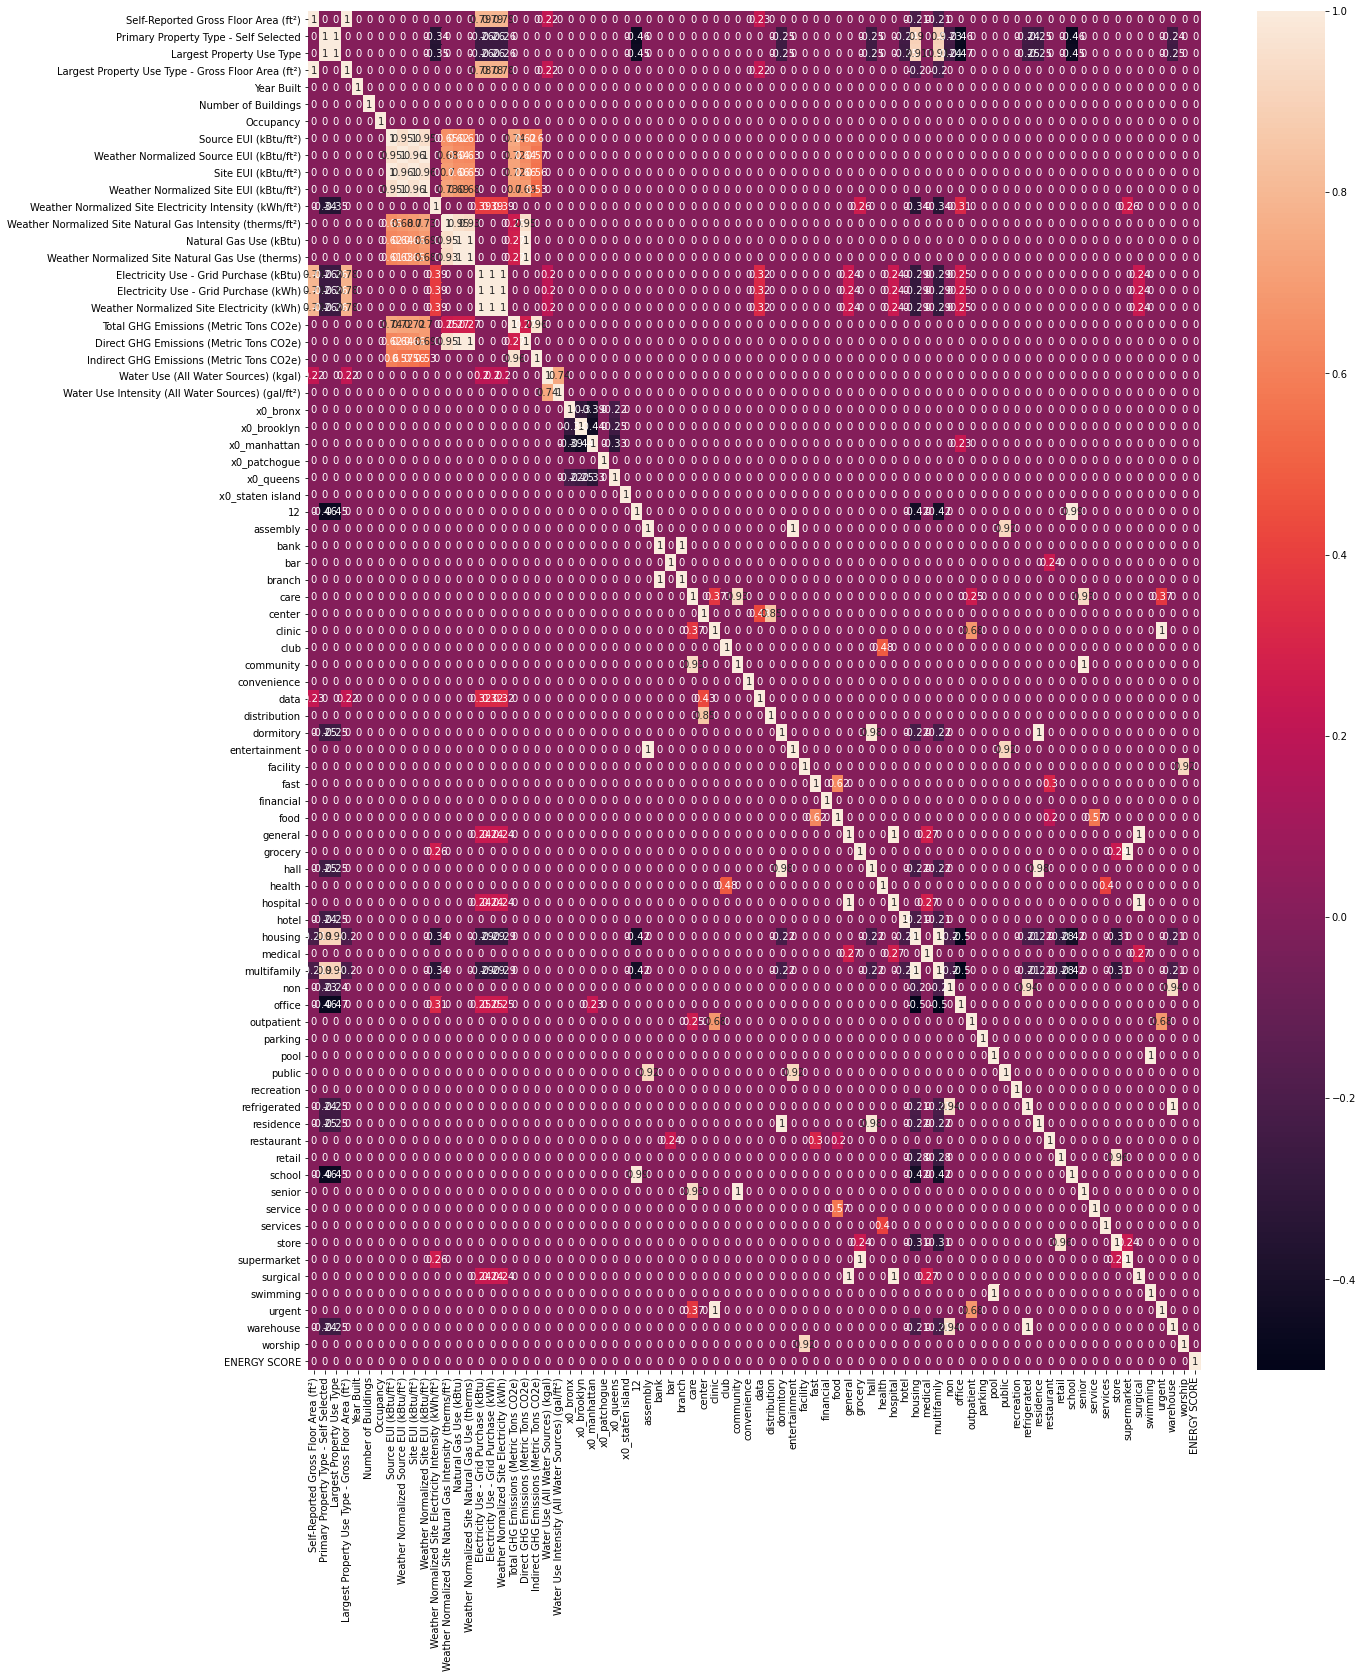

In [520]:

X_corr = X_train.copy()
X_corr['ENERGY SCORE'] = y_train

corraltion_matrix = X_corr.corr().round(2)
corraltion_matrix[np.abs(corraltion_matrix) < 0.2] =0

plt.subplots(figsize=(20, 25))
sns.heatmap(data=corraltion_matrix, annot=True)


## Преобразуем номинативные переменные

Borough

In [501]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_train[['Borough']])

X_train_ohe = ohe.transform((X_train[['Borough']]))
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names())
X_train_ohe

,x0_bronx,x0_brooklyn,x0_manhattan,x0_patchogue,x0_queens,x0_staten island
0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
20358,0.0,1.0,0.0,0.0,0.0,0.0
20359,1.0,0.0,0.0,0.0,0.0,0.0
20360,0.0,0.0,1.0,0.0,0.0,0.0
20361,0.0,0.0,1.0,0.0,0.0,0.0


In [502]:
X_test_ohe = ohe.transform((X_test[['Borough']]))
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names())
X_test_ohe

,x0_bronx,x0_brooklyn,x0_manhattan,x0_patchogue,x0_queens,x0_staten island
0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5086,0.0,1.0,0.0,0.0,0.0,0.0
5087,0.0,0.0,1.0,0.0,0.0,0.0
5088,0.0,1.0,0.0,0.0,0.0,0.0
5089,0.0,0.0,0.0,0.0,1.0,0.0


In [503]:
X_train = pd.concat([X_train.reset_index(drop=True),
                     X_train_ohe.reset_index(drop=True)], axis=1)

X_test = pd.concat([X_test.reset_index(drop=True),
                    X_test_ohe.reset_index(drop=True)], axis=1)

In [504]:
X_train = X_train.drop(columns='Borough')
X_test = X_test.drop(columns='Borough')

Primary Property Type - Self Selected

In [505]:
X_train['Primary Property Type - Self Selected'].value_counts()

Multifamily Housing                           15204
Office                                         1876
K-12 School                                    1177
Residence Hall/Dormitory                        370
Hotel                                           367
Non-Refrigerated Warehouse                      317
College/University                              215
Senior Care Community                           150
Retail Store                                    126
Distribution Center                              93
Worship Facility                                 85
Supermarket/Grocery Store                        84
Hospital (General Medical & Surgical)            66
Medical Office                                   64
Mixed Use Property                               32
Refrigerated Warehouse                           30
Other                                            26
Courthouse                                       20
Financial Office                                 14
Bank Branch 

In [506]:
X_train['Largest Property Use Type'].value_counts()

Multifamily Housing                      15216
Office                                    1918
K-12 School                               1381
Hotel                                      372
Residence Hall/Dormitory                   371
Non-Refrigerated Warehouse                 318
Senior Care Community                      155
Retail Store                               152
Distribution Center                         95
Worship Facility                            90
Supermarket/Grocery Store                   85
Hospital (General Medical & Surgical)       66
Medical Office                              62
Refrigerated Warehouse                      27
Courthouse                                  20
Financial Office                            15
Bank Branch                                 10
Wholesale Club/Supercenter                   6
Data Center                                  2
Parking                                      2
Name: Largest Property Use Type, dtype: int64

In [507]:
ce1 = CountEncoder(handle_unknown=-1)

cols_name = ['Primary Property Type - Self Selected', 'Largest Property Use Type']
ce1.fit(X_train[cols_name])

X_train[cols_name] = ce1.transform(X_train[cols_name])
X_test[cols_name] = ce1.transform(X_test[cols_name])

List of All Property Use Types at Property

In [508]:
X_train['List of All Property Use Types at Property']

0                                      Multifamily Housing
1                                      Multifamily Housing
2                                      Multifamily Housing
3        Enclosed Mall, Fitness Center/Health Club/Gym,...
4                                                   Office
                               ...                        
20358                                  Multifamily Housing
20359                                  Multifamily Housing
20360                                  Multifamily Housing
20361                                  Multifamily Housing
20362                                  Multifamily Housing
Name: List of All Property Use Types at Property, Length: 20363, dtype: object

In [509]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')

tfidf.fit(X_train['List of All Property Use Types at Property'])

TfidfVectorizer(max_features=50, stop_words='english')

In [510]:
X_train_tfidf = tfidf.transform(X_train['List of All Property Use Types at Property']).toarray()
X_train_tfidf = pd.DataFrame(X_train_tfidf, columns=tfidf.get_feature_names())
X_train_tfidf

,12,assembly,bank,bar,branch,care,center,clinic,club,community,...,senior,service,services,store,supermarket,surgical,swimming,urgent,warehouse,worship
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.315505,0.0,0.412569,0.0,...,0.0,0.0,0.0,0.210978,0.323548,0.0,0.367676,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20358,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
20359,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
20360,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
20361,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [511]:
X_test_tfidf = tfidf.transform(X_test['List of All Property Use Types at Property']).toarray()
X_test_tfidf = pd.DataFrame(X_test_tfidf, columns=tfidf.get_feature_names())
X_test_tfidf

,12,assembly,bank,bar,branch,care,center,clinic,club,community,...,senior,service,services,store,supermarket,surgical,swimming,urgent,warehouse,worship
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.553726,0.0,0.0,0.0,0.0,0.0,0.000000
5087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.658982


In [512]:
X_train = pd.concat([X_train.reset_index(drop=True),
                     X_train_tfidf.reset_index(drop=True)], axis=1)

X_test = pd.concat([X_test.reset_index(drop=True),
                    X_test_tfidf.reset_index(drop=True)], axis=1)

In [513]:
X_train.drop(columns='List of All Property Use Types at Property', inplace=True)
X_test.drop(columns='List of All Property Use Types at Property', inplace=True)

In [514]:
X_train.shape, X_test.shape

((20363, 79), (5091, 79))

## Заполним пропуски

In [515]:
(X_train.isna().sum() / X_train.shape[0]).sort_values()

Self-Reported Gross Floor Area (ft²)                          0.000000
multifamily                                                   0.000000
medical                                                       0.000000
housing                                                       0.000000
hotel                                                         0.000000
                                                                ...   
Weather Normalized Source EUI (kBtu/ft²)                      0.105780
Weather Normalized Site Natural Gas Use (therms)              0.113785
Weather Normalized Site Natural Gas Intensity (therms/ft²)    0.113785
Water Use (All Water Sources) (kgal)                          0.434808
Water Use Intensity (All Water Sources) (gal/ft²)             0.434808
Length: 79, dtype: float64

In [517]:
cols_name = X_train.columns

knn_imputer = KNNImputer()
knn_imputer.fit(X_train[cols_name])


KNNImputer()

In [518]:
%%time
X_train[cols_name] = knn_imputer.transform(X_train[cols_name])
X_test[cols_name] = knn_imputer.transform(X_test[cols_name])

CPU times: user 1min 34s, sys: 12.4 s, total: 1min 46s
Wall time: 1min 50s


In [519]:
cols_name = X_train.columns

mms = MinMaxScaler()
mms.fit(X_train)

X_train[cols_name] = mms.transform(X_train[cols_name])
X_test[cols_name] = mms.transform(X_test[cols_name])

# Обучим модель

In [521]:
regr = GradientBoostingRegressor(random_state=1)


regr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

In [522]:
pred_train_1 = regr.predict(X_train)
pred_test_1 = regr.predict(X_test)

print(f'R2 score train {r2_score(y_train, pred_train_1):.2f}')
print(f'R2 score test {r2_score(y_test, pred_test_1):.2f}')

R2 score train 0.84
R2 score test 0.83


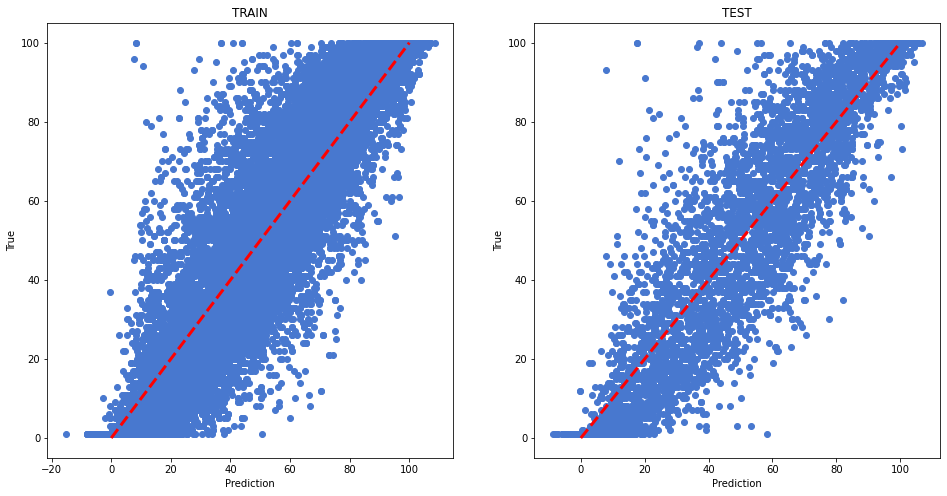

In [523]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].scatter(pred_train, y_train)
ax[0].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('True')
ax[0].set_title('TRAIN')

ax[1].scatter(pred_test, y_test)
ax[1].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('True')
ax[1].set_title('TEST');

Text(0, 0.5, 'Features')

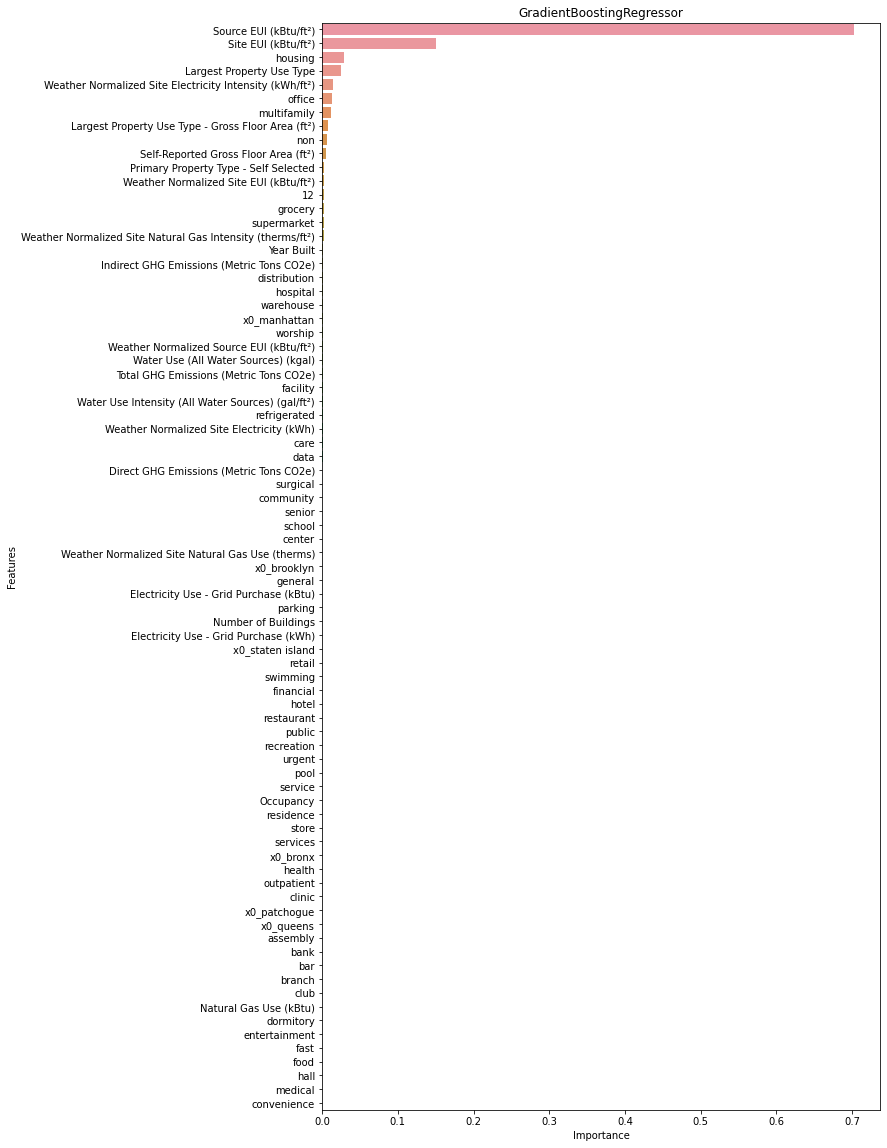

In [524]:
feature_importance = pd.DataFrame(
    {'feature': list(X_train.columns),'importance': regr.feature_importances_}
).sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 20))
sns.barplot(x=feature_importance['importance'], y=feature_importance['feature'])
plt.title('GradientBoostingRegressor')
plt.xlabel('Importance')
plt.ylabel('Features')

In [526]:
%%time

params = {
    'max_depth': [ 5, 7],
    'n_estimators': [ 70, 80]
}
gs = GridSearchCV(estimator=regr,
                  param_grid=params,
                  scoring='r2')

gs.fit(X_train, y_train)

CPU times: user 6min 6s, sys: 4.77 s, total: 6min 11s
Wall time: 6min 47s


GridSearchCV(estimator=GradientBoostingRegressor(random_state=1),
             param_grid={'max_depth': [5, 7], 'n_estimators': [70, 80]},
             scoring='r2')

In [527]:
gs.best_params_, gs.best_score_

({'max_depth': 7, 'n_estimators': 80}, 0.8672242195571942)

In [528]:
%%time

regr = GradientBoostingRegressor(
    max_depth=7,
    n_estimators=80,
    random_state=1
)

regr.fit(X_train, y_train)

pred_train_2 = regr.predict(X_train)
pred_test_2 = regr.predict(X_test)

CPU times: user 26 s, sys: 243 ms, total: 26.3 s
Wall time: 28.8 s


In [529]:
print(f'R2 score train {r2_score(y_train, pred_train_2):.2f}')
print(f'R2 score test {r2_score(y_test, pred_test_2):.2f}')

R2 score train 0.91
R2 score test 0.86


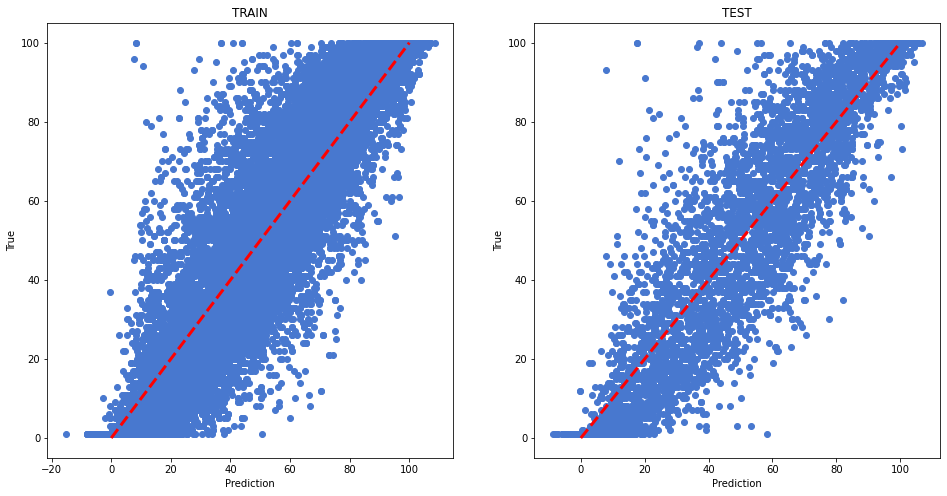

In [530]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].scatter(pred_train_2, y_train)
ax[0].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('True')
ax[0].set_title('TRAIN')

ax[1].scatter(pred_test_2, y_test)
ax[1].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('True')
ax[1].set_title('TEST');

In [531]:
%%time
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias = False)
X_train_2 = poly.fit_transform(X_train)
X_train_2 = pd.DataFrame(X_train_2, columns = poly.get_feature_names(X_train.columns))
X_test_2 = poly.transform(X_test)
X_test_2 = pd.DataFrame(X_test_2, columns = poly.get_feature_names(X_test.columns))


CPU times: user 710 ms, sys: 292 ms, total: 1 s
Wall time: 1.53 s


In [533]:
X_train_2.head()

,Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,surgical swimming,surgical urgent,surgical warehouse,surgical worship,swimming urgent,swimming warehouse,swimming worship,urgent warehouse,urgent worship,warehouse worship
0,0.004502,1.000000,1.000000,0.004502,0.745946,0.006211,0.95,0.000683,0.000722,0.000572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003364,1.000000,1.000000,0.003364,0.724324,0.006211,0.95,0.000554,0.000579,0.000373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.008570,1.000000,1.000000,0.008570,0.762162,0.006211,1.00,0.000611,0.000652,0.000501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.123261,1.000000,1.000000,0.119132,0.970270,0.012422,1.00,0.000675,0.000812,0.000414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.010279,0.123331,0.125937,0.010279,0.845946,0.006211,1.00,0.000419,0.000423,0.000174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [534]:
regr2 =GradientBoostingRegressor(
    max_depth=7,
    n_estimators=80,
    random_state=1
)

In [535]:
%%time
regr2.fit(X_train_2, y_train)

pred_train_3 = regr2.predict(X_train_2)
pred_test_3 = regr2.predict(X_test_2)

In [536]:
print(f'R2 score train {r2_score(y_train, pred_train):.2f}')
print(f'R2 score test {r2_score(y_test, pred_test):.2f}')

R2 score train 0.92
R2 score test 0.87


In [537]:
feature_scores = pd.Series(regr2.feature_importances_, index=X_train_2.columns).sort_values(ascending=False)
feature_scores.head(30)

Source EUI (kBtu/ft²)                                                                                0.602117
Largest Property Use Type Source EUI (kBtu/ft²)                                                      0.117595
Site EUI (kBtu/ft²)                                                                                  0.080921
Largest Property Use Type - Gross Floor Area (ft²) office                                            0.010181
Largest Property Use Type Weather Normalized Site Electricity Intensity (kWh/ft²)                    0.009165
Occupancy Site EUI (kBtu/ft²)                                                                        0.008198
Self-Reported Gross Floor Area (ft²) office                                                          0.006228
Source EUI (kBtu/ft²) multifamily                                                                    0.005884
Source EUI (kBtu/ft²) housing                                                                        0.005720
Source EUI

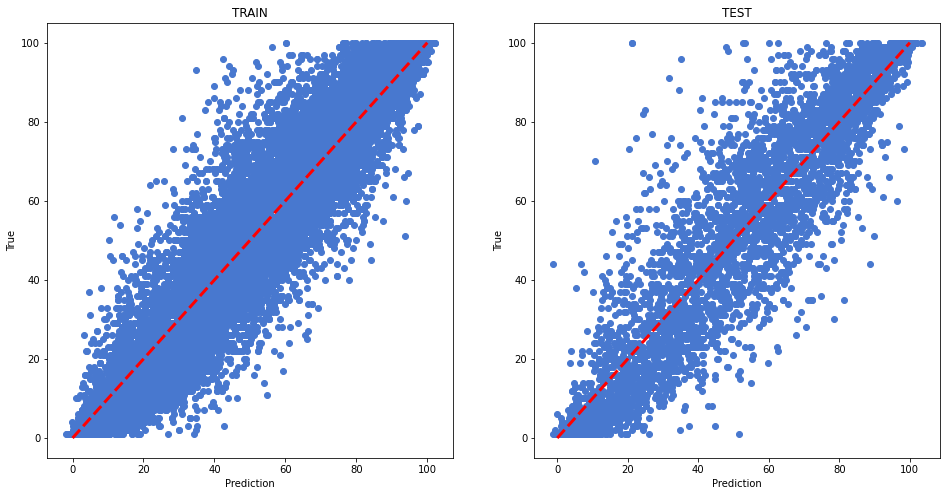

In [538]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].scatter(pred_train_3, y_train)
ax[0].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('True')
ax[0].set_title('TRAIN')

ax[1].scatter(pred_test_3, y_test)
ax[1].plot([0, 100], [0, 100], '--', c='r', linewidth=3)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('True')
ax[1].set_title('TEST');